In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download kaustubhb999/tomatoleaf

 99% 177M/179M [00:05<00:00, 37.4MB/s]
100% 179M/179M [00:05<00:00, 33.9MB/s]


In [ ]:
! unzip /content/tomatoleaf.zip

In [52]:
import os
num_classes=len(os.listdir("/content/tomato/train"))
num_classes

10

In [53]:
from keras.preprocessing.image import ImageDataGenerator

In [54]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
training_set = train_datagen.flow_from_directory(
    '/content/tomato/train',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical' )

test_set=test_datagen.flow_from_directory(
    '/content/tomato/val',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical' )

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [12]:
label_map = (training_set.class_indices)

print(label_map)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [13]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [14]:
def display_random_images(directory, num_images=9, num_columns=3):
    subfolders = [subfolder for subfolder in os.listdir(directory) if os.path.isdir(os.path.join(directory, subfolder))]
    if len(subfolders) == 0:
        print(f"No subfolders found in {directory}")
        return

    random_subfolder = random.choice(subfolders)
    subfolder_path = os.path.join(directory, random_subfolder)
    image_files = [filename for filename in os.listdir(subfolder_path) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) < num_images:
        print(f"Number of available images in {subfolder_path} is less than {num_images}")
        return

    random_files = random.sample(image_files, num_images)
    num_rows = (num_images + num_columns - 1) // num_columns
    plt.figure(figsize=(15, 10))

    for i, filename in enumerate(random_files):
        img_path = os.path.join(subfolder_path, filename)
        img = mpimg.imread(img_path)
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)

    plt.tight_layout()
    plt.show()

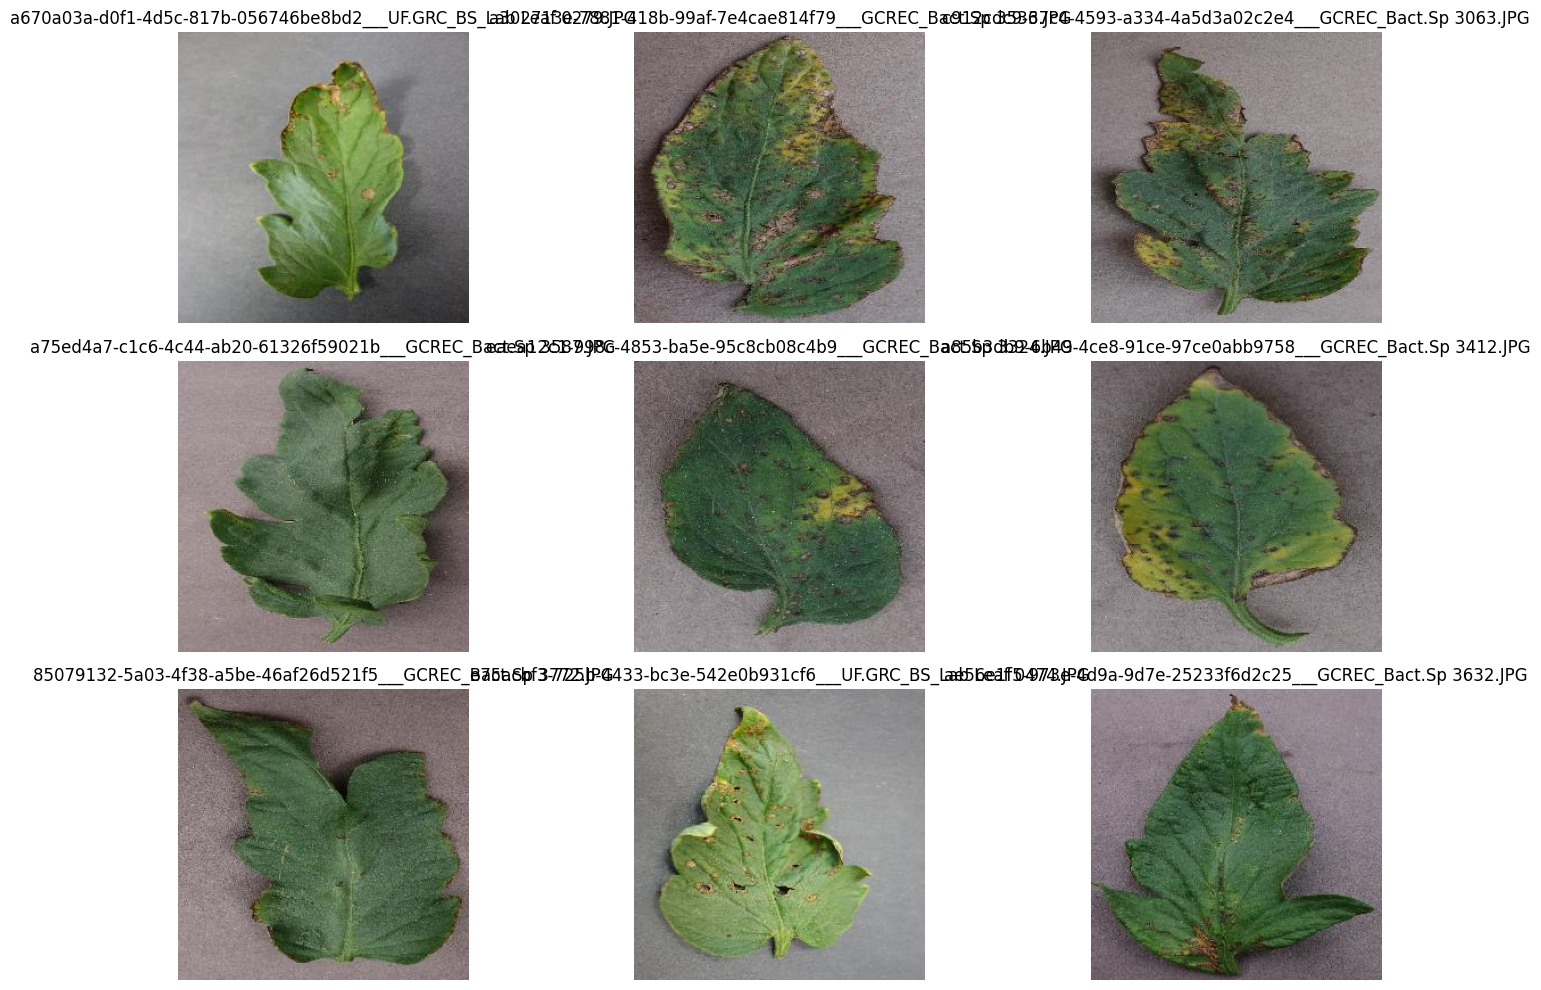

In [15]:
display_random_images('/content/tomato/train', num_images=9, num_columns=3)

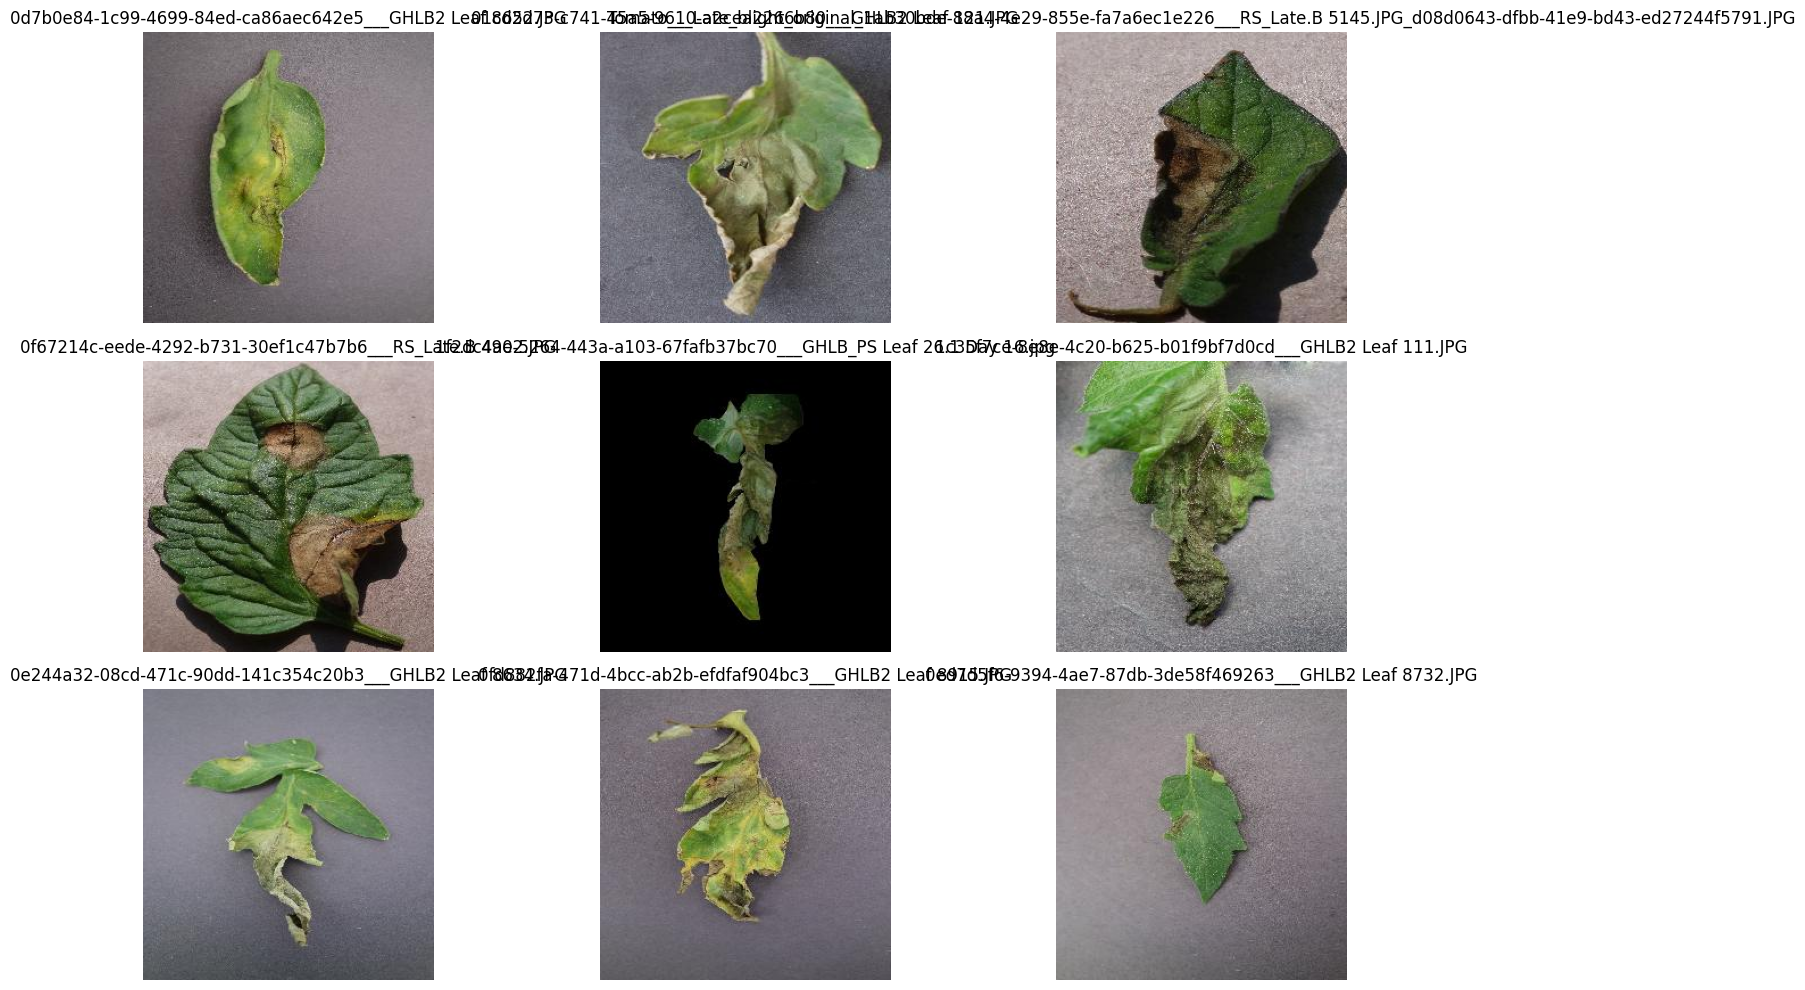

In [16]:
display_random_images('/content/tomato/val', num_images=9, num_columns=3)

In [17]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

In [18]:
import numpy as np

In [48]:
images, labels = training_set.next()

len(images), len(labels), images[0].shape

(64, 64, (128, 128, 3))

In [50]:
images1, labels1 = test_set.next()
len(images1), len(labels1), images1[0].shape

(64, 64, (128, 128, 3))

In [19]:
classifier = Sequential()

In [20]:
classifier.add(Convolution2D(32, (3, 3), padding='same', input_shape = (128,128, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2),padding='same'))
classifier.add(Convolution2D(64, 3, 3, activation = 'relu',padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2),padding='same'))
classifier.add(Convolution2D(128, 3, 3, activation = 'relu',padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2),padding='same'))

In [21]:
classifier.add(Flatten())

In [22]:
#hidden layer
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dropout(0.5))

In [23]:
#output layer
classifier.add(Dense(num_classes, activation = 'softmax'))

In [24]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())
#plot_model(classifier, show_shapes=True, to_file='PlantVillage_CNN.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [25]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = classifier.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=50,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/50
157/157 [==============================] - 186s 1s/step - loss: 1.9729 - accuracy: 0.2780 - val_loss: 1.4500 - val_accuracy: 0.4410
Epoch 2/50
157/157 [==============================] - 191s 1s/step - loss: 1.1269 - accuracy: 0.6051 - val_loss: 1.2051 - val_accuracy: 0.5760
Epoch 3/50
157/157 [==============================] - 186s 1s/step - loss: 0.8537 - accuracy: 0.6988 - val_loss: 0.7068 - val_accuracy: 0.7580
Epoch 4/50
157/157 [==============================] - 191s 1s/step - loss: 0.7416 - accuracy: 0.7400 - val_loss: 0.7827 - val_accuracy: 0.7440
Epoch 5/50
157/157 [==============================] - 186s 1s/step - loss: 0.6252 - accuracy: 0.7821 - val_loss: 0.6520 - val_accuracy: 0.7730
Epoch 6/50
157/157 [==============================] - 185s 1s/step - loss: 0.6016 - accuracy: 0.7846 - val_loss: 0.8219 - val_accuracy: 0.7210
Epoch 7/50
157/157 [==============================] - 190s 1s/step - loss: 0.5496 - accuracy: 0.8078 - val_loss: 0.6685 - val_accuracy: 0.7720

In [28]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [29]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [41]:
# Make predictions on test data
test_loss, test_accuracy = classifier.evaluate(test_set, steps=len(test_set))
print(f"Test Loss: {test_loss*100:.4f} %")
print(f"Test Accuracy: {test_accuracy*100:.4f} %")

16/16 [==============================] - 8s 516ms/step - loss: 0.3228 - accuracy: 0.9080
Test Loss: 32.2765 %
Test Accuracy: 90.8000 %


In [32]:
# Save the trained model
classifier.save("CNN_model_1.h5")
print("Trained model saved as 'CNN_model_1.h5'")

Trained model saved as 'CNN_model_1.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("CNN_model_1.h5")

In [69]:
# Initialize variables
num_samples = len(test_set.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

In [70]:
# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(test_set)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

2/2 [==============================] - 0s 119ms/step


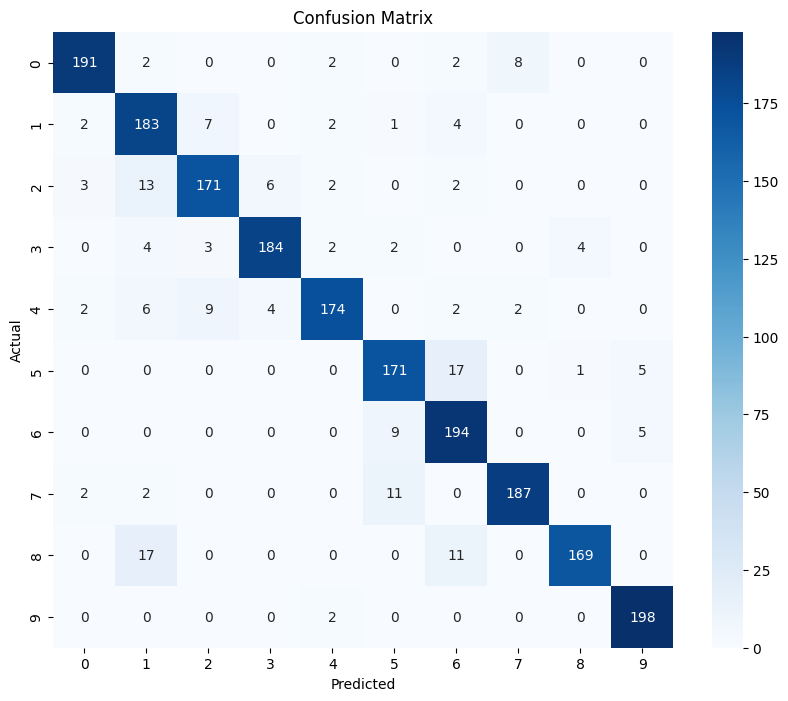

In [71]:
# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [72]:
images, labels = training_set.next()

len(images), len(labels), images[0].shape

(64, 64, (128, 128, 3))

In [73]:
images1, labels1 = test_set.next()

len(images1), len(labels1), images1[0].shape

(64, 64, (128, 128, 3))

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [76]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(128,128))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed

In [85]:
def predict(img_path):
  t=cv2.imread(img_path)
  plt.imshow(t)

  img = preprocess_images(img_path)
  prediction = loaded_model.predict(img)

  predicted_class_index = np.argmax(prediction)

  class_labels = ["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight","Tomato___Leaf_Mold"
                ,"Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite",
                "Tomato___Target_Spot","Tomato___Tomato_Yellow_Leaf_Curl_Virus","Tomato___Tomato_mosaic_virus",
                "Tomato___healthy"]

  predicted_class_label = class_labels[predicted_class_index]

  print("Predicted class    :   ", predicted_class_label)

In [ ]:
import cv2

1/1 [==============================] - 0s 24ms/step
Predicted class    :    Tomato___Bacterial_spot


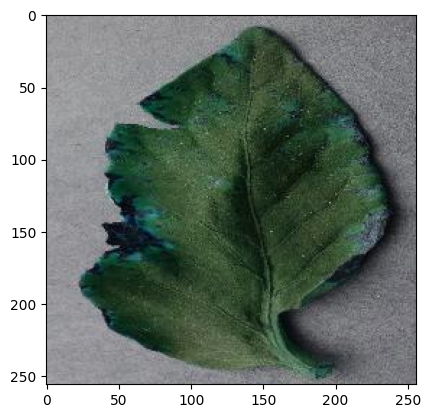

In [99]:
img_path = "/content/tomato/val/Tomato___Bacterial_spot/0f81cc91-5b9b-4061-a127-74105ebbcccf___GCREC_Bact.Sp 6305.JPG"
predict(img_path)

In [100]:
img_path = "/content/tomato/val/Tomato___Early_blight/Tomato___Early_blight_original_1c9e0f1a-7314-449c-9482-9059684ac82d___RS_Erly.B 7840.JPG_949a751a-4ac4-45d5-b63f-4da85982c869.JPG"
predict(img_path)

1/1 [==============================] - 0s 105ms/step
Predicted class    :    Tomato___Early_blight


1/1 [==============================] - 0s 119ms/step
Predicted class    :    Tomato___Late_blight


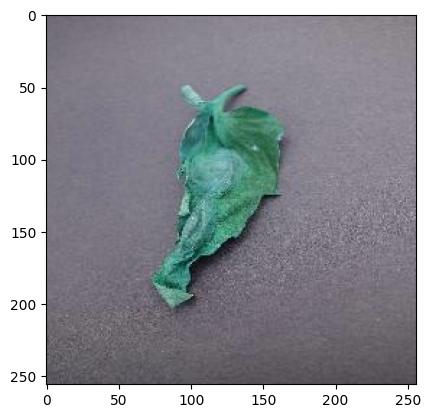

In [101]:
img_path = "/content/tomato/val/Tomato___Late_blight/0f575c94-5c7d-4058-9e65-9046572f9370___GHLB2 Leaf 8956.JPG"
predict(img_path)

In [102]:
img_path = "/content/tomato/val/Tomato___Leaf_Mold/2a15214d-cee6-4359-8baa-7281f3fc0182___Crnl_L.Mold 8672.JPG"
predict(img_path)

1/1 [==============================] - 0s 79ms/step
Predicted class    :    Tomato___Leaf_Mold


In [103]:
img_path = "/content/tomato/val/Tomato___Septoria_leaf_spot/1f7fb33a-b74e-465c-ac76-8c3866931a3d___Keller.St_CG 2011.JPG"
predict(img_path)

1/1 [==============================] - 0s 39ms/step
Predicted class    :    Tomato___Septoria_leaf_spot


In [104]:
img_path = "/content/tomato/val/Tomato___Spider_mites Two-spotted_spider_mite/Tomato___Spider_mites Two-spotted_spider_mite_original_00fa99e8-2605-4d72-be69-98277587d84b___Com.G_SpM_FL 1453.JPG_7869a40f-45b5-4912-b358-2bcc41d5322c.JPG"
predict(img_path)

1/1 [==============================] - 0s 45ms/step
Predicted class    :    Tomato___Spider_mites Two-spotted_spider_mite


1/1 [==============================] - 0s 41ms/step
Predicted class    :    Tomato___Target_Spot


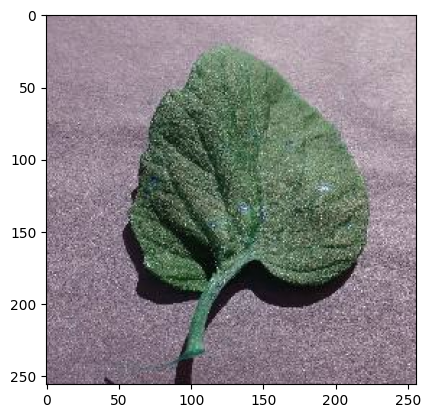

In [105]:
img_path = "/content/tomato/val/Tomato___Target_Spot/0eaa45be-4346-4e3c-ab6f-4ce9f9aec1db___Com.G_TgS_FL 7902.JPG"
predict(img_path)

In [98]:
img_path = "/content/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus/cfdbbfba-3cdc-4aa2-9c43-cddeff7f6d73___YLCV_NREC 0309.JPG"
predict(img_path)

1/1 [==============================] - 0s 86ms/step
Predicted class    :    Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [96]:
img_path = "/content/tomato/val/Tomato___Tomato_mosaic_virus/0c779116-043c-4715-b080-16be2e8d2552___PSU_CG 2285.JPG"
predict(img_path)

1/1 [==============================] - 0s 96ms/step
Predicted class    :    Tomato___Tomato_mosaic_virus


In [97]:
img_path = "/content/tomato/val/Tomato___healthy/0a86ddc0-4950-4efc-9260-0f16d4db046b___RS_HL 0469.JPG"
predict(img_path)

1/1 [==============================] - 0s 94ms/step
Predicted class    :    Tomato___healthy
